In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerNN, KerasRNN
from sklearn import metrics

Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


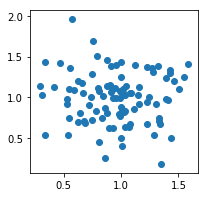

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

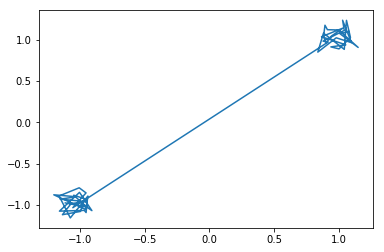

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 10  # stickyness parameter
alfa = 1.00  # concentration parameter
beta = 0.1 # transition noise
eta =  0.1  # learning rate


# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
        
    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

### Linear dynamical solution (analytic)

Adjusted Mutual Information: -8.17446246292e-17
Adjusted Rand Score: 0.0

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


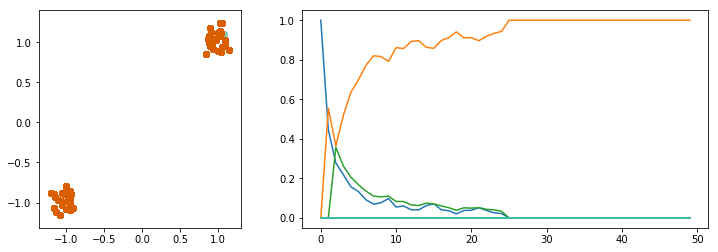

In [6]:
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Adjusted Mutual Information: -8.17446246292e-17
Adjusted Rand Score: 0.0

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


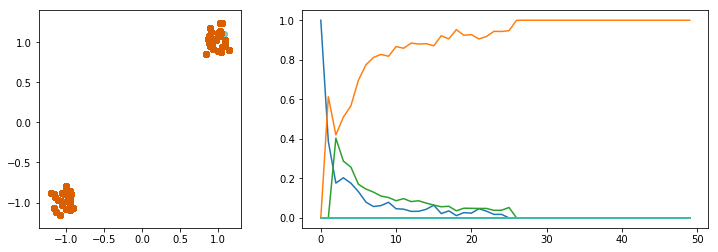

In [7]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasLDS, f_opts=dict())

sem2 = SEM(**sem_kwargs)
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Adjusted Mutual Information: 0.568533764563
Adjusted Rand Score: 0.778873474845

[0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


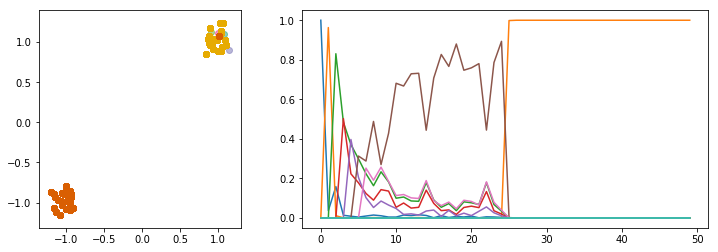

In [8]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasMultiLayerNN, f_opts=dict())

sem3 = SEM(**sem_kwargs)
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Adjusted Mutual Information: 0.0520589371626
Adjusted Rand Score: 0.111280892905

[ 0  1  2  3  4  5  6  7  8  9 10 11  9  9  9  9 11  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9]


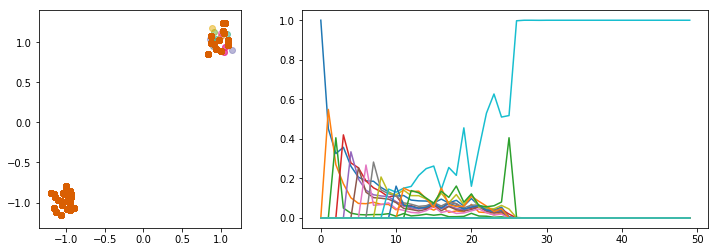

In [9]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasRNN, f_opts=dict(t=5))

sem4 = SEM(**sem_kwargs)
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# Alternating between 2 static events


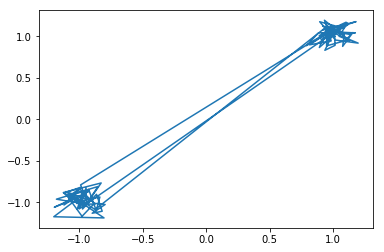

In [10]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


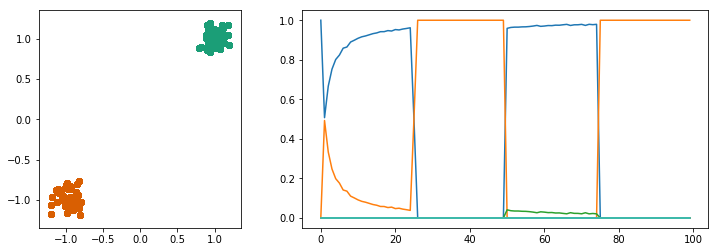

In [11]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Adjusted Mutual Information: 0.325203238013
Adjusted Rand Score: 0.265196881187

[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


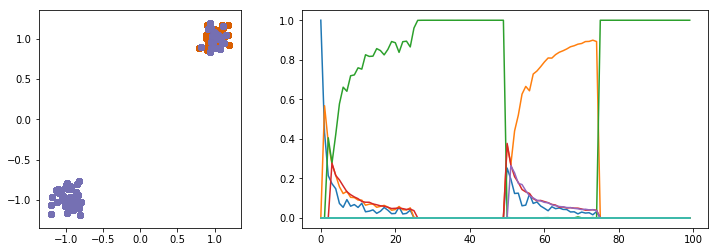

In [12]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Adjusted Mutual Information: 0.760271801184
Adjusted Rand Score: 0.902964959569

[0 1 2 3 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


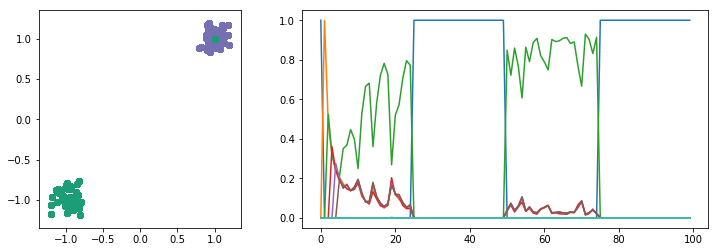

In [13]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Adjusted Mutual Information: 0.451452252816
Adjusted Rand Score: 0.738786279683

[ 0  1  2  3  4  5  6  7  8  9 10 11  6  6  6  6  6 12  6  6  6  6  6  6  6
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 13  6  6  6  6 14  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


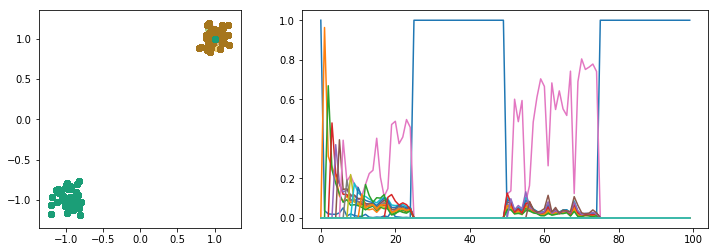

In [14]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

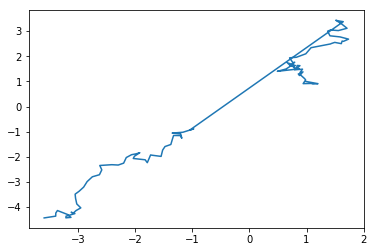

In [15]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


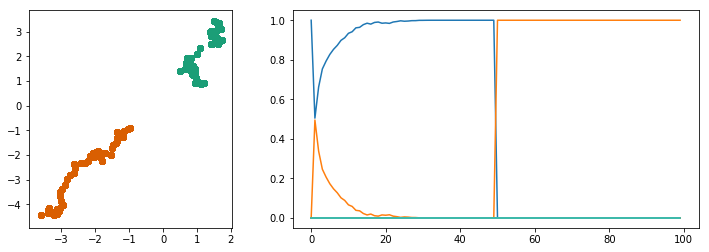

In [16]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Adjusted Mutual Information: 0.932859817055
Adjusted Rand Score: 0.980196039208

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


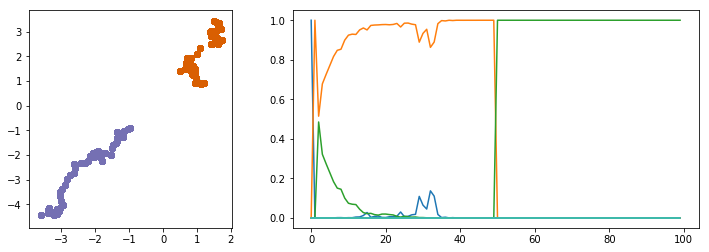

In [17]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Adjusted Mutual Information: 0.540406055128
Adjusted Rand Score: 0.711979671753

[0 1 2 3 1 4 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


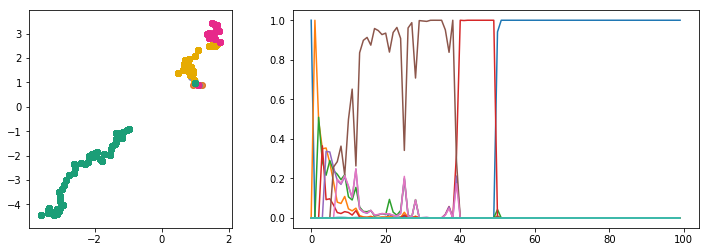

In [18]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Adjusted Mutual Information: 0.540056767506
Adjusted Rand Score: 0.704308334356

[0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 0 0 0 0 0 0 0 0 0 0 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


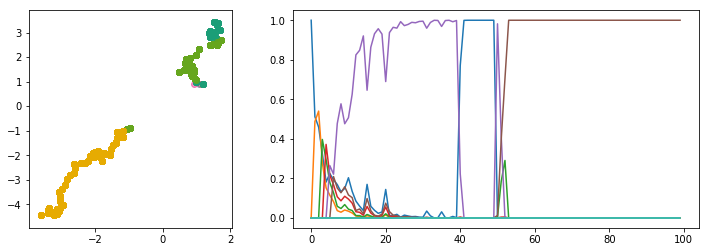

In [19]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


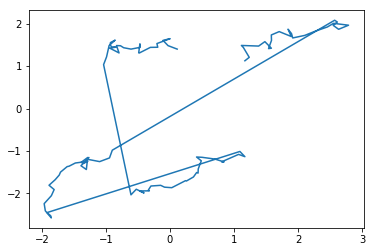

In [20]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


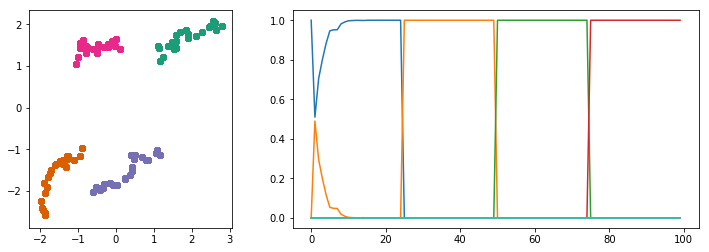

In [21]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Adjusted Mutual Information: 0.914545290254
Adjusted Rand Score: 0.919310035097

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


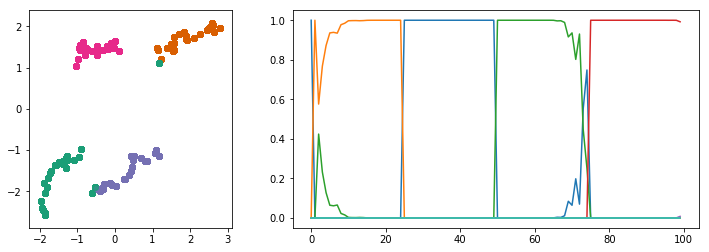

In [22]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Adjusted Mutual Information: 0.873403651771
Adjusted Rand Score: 0.894060114107

[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


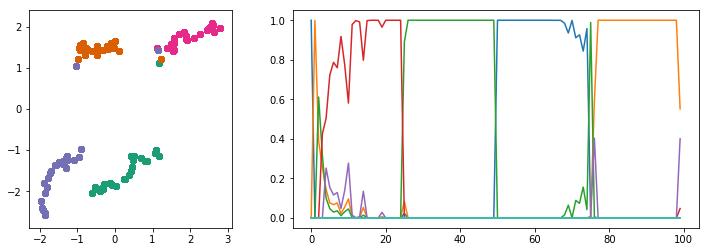

In [23]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Adjusted Mutual Information: 0.96834850278
Adjusted Rand Score: 0.97305763367

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


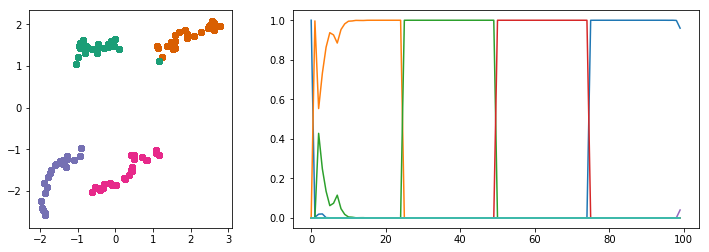

In [24]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)

# 

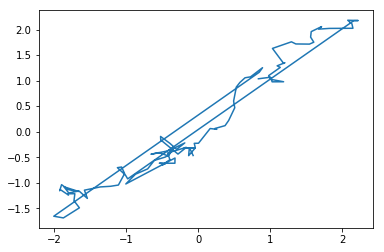

In [28]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Adjusted Mutual Information: 0.744231431589
Adjusted Rand Score: 0.70796460177

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


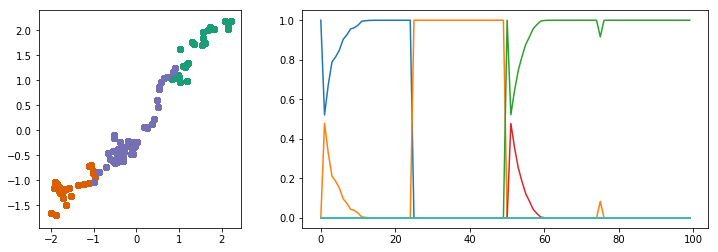

In [29]:
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Adjusted Mutual Information: 0.537633652882
Adjusted Rand Score: 0.553988398457

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


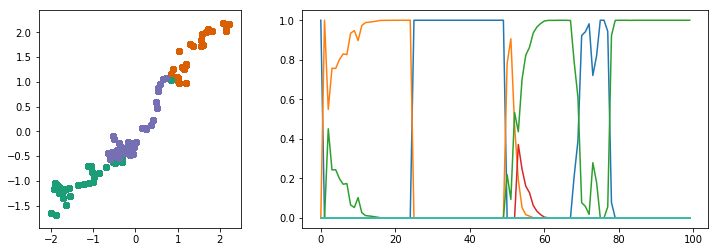

In [30]:
post = sem2.run(x_train, K=K)
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Adjusted Mutual Information: 0.486242794069
Adjusted Rand Score: 0.471593993125

[0 1 2 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 5 5 5 5 5 5 5 5 5 5 5 0 0 5 5 5 5 0 0 0 0
 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


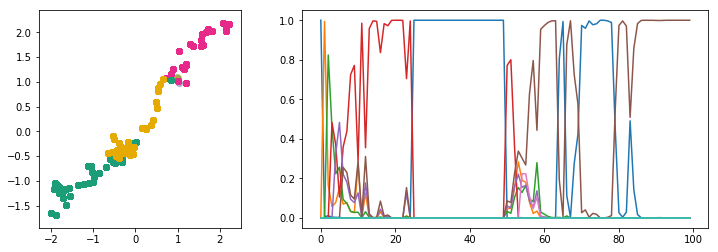

In [31]:
post = sem3.run(x_train, K=K)
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Adjusted Mutual Information: 0.601822933355
Adjusted Rand Score: 0.552514792899

[0 1 2 2 3 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5
 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


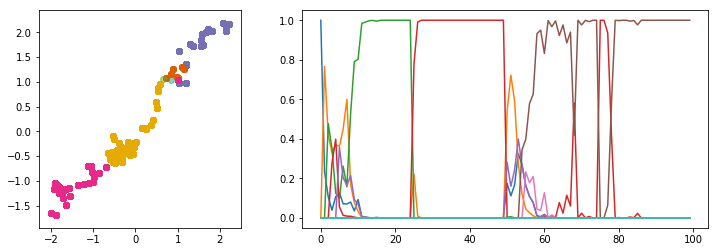

In [32]:
post = sem4.run(x_train, K=K)
plot_segmentation(post, y)